
# 1. Introduction

New York City is the most populous city in the United States, home to over 8.6 million people and over 800 languages. Undoubtedly, food diversity is an important part of a diverse metropolis. The idea of this project is to categorically segment the neighborhoods of New York City into major clusters and examine their cuisines. The intention with this analysis is to examine the neighborhood cluster's food habits and taste. Further examination might reveal if food has any relationship with the diversity of a neighborhood.

This project will help to understand the diversity of a neighborhood by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ machine learning algorithm. Exploratory Data Analysis (EDA) will help to discover further about the culture and diversity of the neighborhood. This project can be utilized by a new food vendor who is willing to open his or her restaurant in a particular neighborhood. Likewise government authorities may examine and study New York City's culture diversity better.


# 2. Data

To examine the above said, following data sources will be used:

    New York City Dataset
        Link: https://geo.nyu.edu/catalog/nyu_2451_34572
        Description: This New York City Neighborhood Names point file was created as a guide to New York City’s neighborhoods that appear on the web resource, “New York: A City of Neighborhoods.” Best estimates of label centroids were established at a 1:1,000 scale, but are ideally viewed at a 1:50,000 scale. This dataset will provide the addresses of neighborhood of NYC in json format. An extract of the json is as follows:

        {'type': 'Feature',
        'id': 'nyu_2451_34572.306',
        'geometry': {'type': 'Point',
        'coordinates': [-74.08173992211962, 40.61731079252983]},
        'geometry_name': 'geom',
        'properties': {'name': 'Fox Hills',
        'stacked': 2,
        'annoline1': 'Fox',
        'annoline2': 'Hills',
        'annoline3': None,
        'annoangle': 0.0,
        'borough': 'Staten Island',
        'bbox': [-74.08173992211962,
        40.61731079252983,
        -74.08173992211962,
        40.61731079252983]}}

    Foursquare API:
        Link: https://developer.foursquare.com/docs
        Description: Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. This is the link to Foursquare Venue Category Hierarchy. Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc. An extract of an API call is as follows:

        'categories': [{'id': '4bf58dd8d48988d110941735',
        'name': 'Italian Restaurant',
        'pluralName': 'Italian Restaurants',
        'shortName': 'Italian',
        'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
        'suffix': '.png'},
        'primary': True}],
        'verified': False,
        'stats': {'tipCount': 17},
        'url': 'http://eccorestaurantny.com',
        'price': {'tier': 4, 'message': 'Very Expensive', 'currency'



# 3. Methodology
Install the appropriate dependencies

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [6]:
import json

In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage


### Download and Explore New York City Dataset

In order to segment the neighborhoods of New York City, a dataset is required that contains the 5 boroughs and the neighborhoods, that exist in each borough, with respective latitude and longitude coordinates.

This dataset exists for free on the web. Here is the link

    To the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572, and
    To its downloadable json format file: https://cocl.us/new_york_dataset/newyork_data.json



In [8]:
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')


Data downloaded!


In [9]:
# open & load downloaded file, print its type
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [10]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


In [11]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


In [12]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [13]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [14]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [16]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [17]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [18]:
CLIENT_ID = 'PV2NQ1XNUGWWN2MWDFWQOVKV34VDCJJK1XMC1EVCR22FNKV1' # your Foursquare ID
CLIENT_SECRET = 'QFIJUU2UKKD351PDRHKBJUFURG2AOPN0XQGS4JTECH3HA1UN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PV2NQ1XNUGWWN2MWDFWQOVKV34VDCJJK1XMC1EVCR22FNKV1
CLIENT_SECRET:QFIJUU2UKKD351PDRHKBJUFURG2AOPN0XQGS4JTECH3HA1UN


In [19]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [20]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [21]:
category_list = category_results['response']['categories']

In [22]:
len(category_list)

10

In [23]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [24]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [25]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [26]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

In [27]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [28]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=PV2NQ1XNUGWWN2MWDFWQOVKV34VDCJJK1XMC1EVCR22FNKV1&client_secret=QFIJUU2UKKD351PDRHKBJUFURG2AOPN0XQGS4JTECH3HA1UN&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [29]:
results = requests.get(url).json()

In [30]:
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1579110058',
  'hasPerk': False}]

In [31]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [33]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


# 4. Analysis and Machine Learning

In [34]:
print(nyc_venues.shape)
nyc_venues.head()

(13933, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
1,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,McDonald's,40.902645,-73.849485,Fast Food Restaurant
4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant


In [35]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 198 uniques categories.


Venue Category
Deli / Bodega                               1073
Pizza Place                                 1034
Coffee Shop                                  895
Donut Shop                                   645
Chinese Restaurant                           624
Fast Food Restaurant                         621
Italian Restaurant                           555
Bakery                                       554
American Restaurant                          428
Café                                         397
Bagel Shop                                   362
Caribbean Restaurant                         352
Sandwich Place                               312
Mexican Restaurant                           309
Diner                                        298
Fried Chicken Joint                          289
Restaurant                                   232
Ice Cream Shop                               224
Food                                         212
Burger Joint                                 185
Food 

In [36]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Food, Dessert Shop, Ice Cream Shop, Fast Food Restaurant, Caribbean Restaurant, Comfort Food Restaurant, Sandwich Place, Donut Shop, Fried Chicken Joint, Chinese Restaurant, Deli / Bodega, Latin American Restaurant, Southern / Soul Food Restaurant, American Restaurant, Pizza Place, Steakhouse, Burger Joint, Spanish Restaurant, Food Truck, Bagel Shop, Bakery, Mexican Restaurant, Seafood Restaurant, Coffee Shop, Frozen Yogurt Shop, BBQ Joint, Italian Restaurant, Restaurant, Dumpling Restaurant, Diner, Café, Juice Bar, Asian Restaurant, Breakfast Spot, Grocery Store, Wings Joint, Sushi Restaurant, Japanese Restaurant, Bar, Empanada Restaurant, Tapas Restaurant, Greek Restaurant, Thai Restaurant, New American Restaurant, Indian Restaurant, Vegetarian / Vegan Restaurant, Cuban Restaurant, Lounge, Pub, Irish Pub, Fish & Chips Shop, Gas Station, Salvadoran Restaurant, Cafeteria, Other Nightlife, Soup Place, Arcade, Hot Dog Joint, Snack Place, Food Court, French Restaurant, Convenience Store, 

In [37]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [38]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Afghan Restaurant, South Indian Restaurant, Szechuan Restaurant, Thai Restaurant, Food Service, Lebanese Restaurant, Himalayan Restaurant, Dutch Restaurant, Mexican Restaurant, Australian Restaurant, Russian Restaurant, Fried Chicken Joint, Venezuelan Restaurant, Cajun / Creole Restaurant, Spanish Restaurant, Italian Restaurant, Jewish Restaurant, Vietnamese Restaurant, Taiwanese Restaurant, Ukrainian Restaurant, Brazilian Restaurant, Indonesian Restaurant, Tex-Mex Restaurant, Ramen Restaurant, Portuguese Restaurant, Seafood Restaurant, Ethiopian Restaurant, Japanese Restaurant, Salvadoran Restaurant, Colombian Restaurant, Peruvian Restaurant, Swiss Restaurant, Austrian Restaurant, Pizza Place, Cuban Restaurant, Kebab Restaurant, Dim Sum Restaurant, Modern Greek Restaurant, Hawaiian Restaurant, Moroccan Restaurant, Steakhouse, Turkish Restaurant, Souvlaki Shop, Arepa Restaurant, Indian Restaurant, Paella Restaurant, Persian Restaurant, Falafel Restaurant, Sri Lankan Restaurant, Egyptia

In [39]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3,Wakefield,40.894705,-73.847201,McDonald's,40.902645,-73.849485,Fast Food Restaurant
1,4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
2,5,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
3,7,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
4,10,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint


In [40]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 102 unique FOOD categories.


In [41]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3338 uniques venues.


In [42]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gaming Cafe,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gaming Cafe,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [44]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gaming Cafe,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
nyc_onehot.shape

(6879, 103)

In [46]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gaming Cafe,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [47]:
venue_counts_described = venue_counts.describe().transpose()

In [48]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.364238,2.263339,0.0,0.0,0.0,0.0,35.0
Chinese Restaurant,302.0,2.066225,1.877189,0.0,1.0,2.0,3.0,14.0
Caribbean Restaurant,302.0,1.165563,2.551608,0.0,0.0,0.0,1.0,14.0
Indian Restaurant,302.0,0.294702,0.965814,0.0,0.0,0.0,0.0,12.0
Italian Restaurant,302.0,1.837748,2.093376,0.0,0.0,1.0,3.0,12.0
Pizza Place,302.0,3.423841,2.034379,0.0,2.0,3.0,5.0,10.0
Fast Food Restaurant,302.0,2.056291,1.954672,0.0,0.0,2.0,3.0,10.0
Latin American Restaurant,302.0,0.480132,0.990622,0.0,0.0,0.0,1.0,8.0
Seafood Restaurant,302.0,0.533113,0.825605,0.0,0.0,0.0,1.0,8.0
Thai Restaurant,302.0,0.317881,0.736977,0.0,0.0,0.0,0.0,6.0


In [49]:
venue_top10_list = venue_top10.index.values.tolist()

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

<Figure size 2000x2000 with 10 Axes>

In [51]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gaming Cafe,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.086957,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130435,0.0,0.0,0.0,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.000000,0.173913,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.217391,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.000000,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.105263,0.0,0.0,0.052632,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.210526,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,

In [52]:
nyc_grouped.shape

(302, 103)

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [55]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']


In [56]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant
1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Chinese Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant
3,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant


## Cluster Neighborhoods

In [57]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

In [58]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

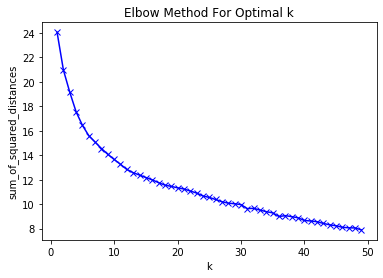

In [59]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [60]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

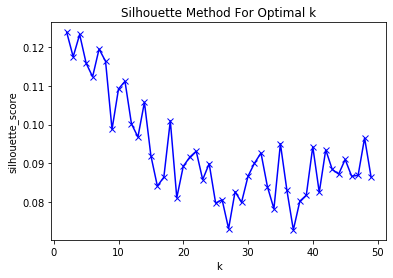

In [61]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [62]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({4: 92, 1: 62, 5: 46, 3: 35, 7: 30, 2: 21, 0: 8, 6: 8})


In [63]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [64]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Allerton,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant
1,5,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Chinese Restaurant
2,5,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant
3,1,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant
4,3,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant


In [65]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,1,Allerton,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,Bronx,40.865788,-73.859319
1,5,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Staten Island,40.538114,-74.178549
2,5,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,1,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
4,3,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124


In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 5. Results

In [67]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]


In [68]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
8,Auburndale,Korean Restaurant,Greek Restaurant,Pizza Place,American Restaurant,Italian Restaurant,Queens,40.761730,-73.791762
14,Bayside,Korean Restaurant,Fast Food Restaurant,American Restaurant,Greek Restaurant,Asian Restaurant,Queens,40.766041,-73.774274
97,Flatiron,Korean Restaurant,American Restaurant,New American Restaurant,Italian Restaurant,Dim Sum Restaurant,Manhattan,40.739673,-73.990947
114,Gramercy,Korean Restaurant,Japanese Restaurant,New American Restaurant,Italian Restaurant,Ramen Restaurant,Manhattan,40.737210,-73.981376
174,Midtown,Korean Restaurant,American Restaurant,Seafood Restaurant,Fast Food Restaurant,Steakhouse,Manhattan,40.754691,-73.981669


In [69]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Korean Restaurant      8
American Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant        4
Fast Food Restaurant       1
New American Restaurant    1
Greek Restaurant           1
Japanese Restaurant        1
Korean Restaurant          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Manhattan    6
Queens       3
Name: Borough, dtype: int64
---------------------------------------------


In [70]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,Bronx,40.865788,-73.859319
3,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
13,Baychester,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Caribbean Restaurant,BBQ Joint,Bronx,40.866858,-73.835798
17,Bedford Stuyvesant,Pizza Place,Fast Food Restaurant,Caribbean Restaurant,Mexican Restaurant,French Restaurant,Brooklyn,40.687232,-73.941785
28,Borough Park,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Latin American Restaurant,Sushi Restaurant,Brooklyn,40.633131,-73.990498


In [71]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant               28
Pizza Place                        19
Caribbean Restaurant                5
Chinese Restaurant                  3
Latin American Restaurant           3
Mexican Restaurant                  1
Fried Chicken Joint                 1
Southern / Soul Food Restaurant     1
Spanish Restaurant                  1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant               21
Pizza Place                        14
Fried Chicken Joint                 8
Chinese Restaurant                  5
Caribbean Restaurant                4
Mexican Restaurant                  2
Latin American Restaurant           2
Filipino Restaurant                 1
American Restaurant                 1
Steakhouse                          1
New American Restaurant             1
Southern / Soul Food Restaurant     1
Spanish Restaurant                  1
Name: 2nd Most Common Venue, dtype: int64
----------------------------------

In [72]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
36,Brookville,Fried Chicken Joint,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
37,Brownsville,Pizza Place,Caribbean Restaurant,Chinese Restaurant,Fried Chicken Joint,Seafood Restaurant,Brooklyn,40.663950,-73.910235
41,Cambria Heights,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,Mexican Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Caribbean Restaurant,Pizza Place,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Brooklyn,40.635564,-73.902093
77,East Flatbush,Caribbean Restaurant,Fried Chicken Joint,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Brooklyn,40.641718,-73.936103


In [73]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    16
Pizza Place              3
Fried Chicken Joint      1
Chinese Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place             6
Caribbean Restaurant    5
Fast Food Restaurant    5
Chinese Restaurant      4
Fried Chicken Joint     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn    9
Queens      6
Bronx       6
Name: Borough, dtype: int64
---------------------------------------------


In [74]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124
7,Astoria Heights,Italian Restaurant,Greek Restaurant,Pizza Place,Chinese Restaurant,Sushi Restaurant,Queens,40.770317,-73.894680
18,Beechhurst,Italian Restaurant,Pizza Place,Chinese Restaurant,Taco Place,German Restaurant,Queens,40.792781,-73.804365
22,Belmont,Italian Restaurant,Pizza Place,Fast Food Restaurant,American Restaurant,Latin American Restaurant,Bronx,40.857277,-73.888452
34,Bronxdale,Pizza Place,Italian Restaurant,Mexican Restaurant,Spanish Restaurant,Chinese Restaurant,Bronx,40.852723,-73.861726


In [75]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    26
Pizza Place            8
Mexican Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                13
Italian Restaurant          9
Chinese Restaurant          3
Mexican Restaurant          2
Asian Restaurant            2
Fast Food Restaurant        2
New American Restaurant     1
Greek Restaurant            1
Japanese Restaurant         1
Whisky Bar                  1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    19
Queens            8
Bronx             7
Brooklyn          1
Name: Borough, dtype: int64
---------------------------------------------


In [76]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
6,Astoria,Pizza Place,Greek Restaurant,Empanada Restaurant,Thai Restaurant,Ramen Restaurant,Queens,40.768509,-73.915654
10,Battery Park City,Fast Food Restaurant,French Restaurant,Pizza Place,New American Restaurant,Taco Place,Manhattan,40.711932,-74.016869
11,Bay Ridge,Fast Food Restaurant,American Restaurant,Pizza Place,Middle Eastern Restaurant,Italian Restaurant,Brooklyn,40.625801,-74.030621
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Staten Island,40.553988,-74.139166


In [77]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant            24
Pizza Place                    17
Italian Restaurant             14
Fast Food Restaurant           13
Seafood Restaurant              4
Sushi Restaurant                3
Thai Restaurant                 3
Mexican Restaurant              2
Dim Sum Restaurant              2
New American Restaurant         2
Chinese Restaurant              1
Japanese Restaurant             1
Greek Restaurant                1
BBQ Joint                       1
Asian Restaurant                1
Shanghai Restaurant             1
Eastern European Restaurant     1
Ramen Restaurant                1
Middle Eastern Restaurant       1
Indian Restaurant               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant                 19
American Restaurant                14
Pizza Place                        13
Chinese Restaurant                  8
Mexican Restaurant                  5
Fast Food Restaurant                5
Japa

In [78]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
16,Bedford Park,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Fried Chicken Joint,Spanish Restaurant,Bronx,40.870185,-73.885512
25,Blissville,Pizza Place,Mexican Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Queens,40.737251,-73.932442
26,Bloomfield,Pizza Place,Mexican Restaurant,Italian Restaurant,BBQ Joint,Whisky Bar,Staten Island,40.605779,-74.187256


In [79]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place           45
Seafood Restaurant     1
Mexican Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant           14
Fast Food Restaurant          6
American Restaurant           6
Mexican Restaurant            5
Italian Restaurant            4
Sushi Restaurant              2
Pizza Place                   2
Taco Place                    2
Asian Restaurant              1
BBQ Joint                     1
New American Restaurant       1
Fried Chicken Joint           1
Japanese Restaurant           1
Latin American Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    18
Queens           13
Brooklyn          9
Bronx             7
Name: Borough, dtype: int64
---------------------------------------------


In [80]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
29,Breezy Point,American Restaurant,Pizza Place,Whisky Bar,Halal Restaurant,Falafel Restaurant,Queens,40.557401,-73.925512
35,Brooklyn Heights,American Restaurant,French Restaurant,Pizza Place,Kebab Restaurant,Middle Eastern Restaurant,Brooklyn,40.695864,-73.993782
55,Clason Point,American Restaurant,South American Restaurant,Seafood Restaurant,Whisky Bar,Halal Restaurant,Bronx,40.806551,-73.854144
74,Dumbo,American Restaurant,Pizza Place,Italian Restaurant,Mexican Restaurant,Mediterranean Restaurant,Brooklyn,40.703176,-73.988753
108,Fulton Ferry,American Restaurant,Italian Restaurant,Pizza Place,Seafood Restaurant,Mediterranean Restaurant,Brooklyn,40.703281,-73.995508


In [81]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant    7
Pizza Place            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  3
Italian Restaurant           2
French Restaurant            1
American Restaurant          1
South American Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         4
Staten Island    2
Queens           1
Bronx            1
Name: Borough, dtype: int64
---------------------------------------------


In [82]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Arverne,Chinese Restaurant,Taco Place,Caribbean Restaurant,American Restaurant,Asian Restaurant,Queens,40.589144,-73.791992
9,Bath Beach,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Malay Restaurant,Pizza Place,Brooklyn,40.599519,-73.998752
15,Bayswater,Chinese Restaurant,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Caribbean Restaurant,Queens,40.611322,-73.765968
19,Bellaire,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Spanish Restaurant,Queens,40.733014,-73.738892
21,Bellerose,Pizza Place,Chinese Restaurant,Indian Restaurant,Latin American Restaurant,BBQ Joint,Queens,40.728573,-73.720128


In [83]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant      20
Pizza Place              6
Indian Restaurant        2
Fast Food Restaurant     1
Mexican Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant           9
Pizza Place                  4
Fast Food Restaurant         3
Caribbean Restaurant         3
Italian Restaurant           3
Taco Place                   2
Korean Restaurant            1
Fried Chicken Joint          1
Seafood Restaurant           1
Latin American Restaurant    1
Cantonese Restaurant         1
American Restaurant          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           18
Brooklyn          6
Staten Island     5
Bronx             1
Name: Borough, dtype: int64
---------------------------------------------
